In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as npl
import pandas as pd
import timeit
from random import *
from math import *
from scipy.stats import *
#from __future__ import division


This Notebook is associated with the scientific note we wrote, it only provides a few theoratical explanations and is mainly composed of numerical simulations made to explain the abstarct notions of mathematics behind portfolio theory that we exposed in our article.

# Functions to simulate different portfolios and plot them :

In [2]:
#Data importation
def get_data (name):
    asset = pd.read_csv("Data/Actifs/"+name+"_8ans.csv")
    R_asset = (asset["Close"] - asset["Open"])*100/asset["Open"]
    asset[name+"_Return"]= R_asset
    mean_R_asset = asset[name+"_Return"].mean()
    return np.array(R_asset),mean_R_asset

In [3]:
#Create a matrix R with all the daily return for each asset as well as the vector of expected return 
def generate_R_M (name):
    n = len(name)
    M = np.zeros(n)
    
    df_ret,M[0] = get_data(name[0])
    
    df_ret = pd.DataFrame({name[0]:df_ret})
    for i in range(n-1):
        data,M[i+1] = get_data(name[i+1])
        df_ret[name[i+1]] = data
    
    return df_ret,M

In [4]:
name = ["AAPL",'AMZN',"MSFT","WMT","NASD"]
generate_R_M(name)[0]

,AAPL,AMZN,MSFT,WMT,NASD
0,0.271751,-1.724775,1.077727,0.911794,0.610615
1,-0.102521,0.944322,0.356561,-0.739510,0.062409
2,-1.590631,-1.745918,-0.356214,0.130841,-0.286859
3,-0.552539,-1.522608,-0.587653,-0.223386,0.085287
4,0.798865,2.267161,1.254950,-0.187157,1.087579
...,...,...,...,...,...
2008,0.188918,-0.317382,0.128806,-0.081394,0.027881
2009,-0.134658,0.718959,0.105502,0.823595,0.105790
2010,0.293945,0.199166,0.070049,-0.301322,-0.030402
2011,0.046785,-0.243904,-0.209547,-0.120574,-0.046304


## Initial Problem :

We want to solve the following problem :
$$ P_{ff\sigma } : \left\{\begin{matrix}
sup_{\pi \in A}\mathbb E[R^{\pi}]
\\ 
\ s.c. \  var(R^{\pi})=\sigma^2
\end{matrix}\right.$$

For which we found the solution : 

$$ \pi^{+}(\sigma)=\frac{1}{a}\Sigma^{-1}\textbf{1} + \sqrt{\sigma^2-\frac{1}{a}}\Sigma^{-1}
    \frac{M-\frac{b}{a}\textbf{1}}{\begin{Vmatrix}
M-\frac{b}{a}\textbf{1}
\end{Vmatrix}_{\Sigma^{-1}}}$$

And we can compute its expected profitability : 


$$ m(\sigma)= \pi^{+'}M=\frac{b}{a}+ \sqrt{\sigma^2-\frac{1}{a}}\|M-\frac{b}{a}\textbf{1}\|_{\Sigma^{-1}}$$

with the notations :

Let $R = (R^1,...,R^d)'$ be the vector of assets profitability and denote : $M = E[R] = (m^1,..,m^d)'$ its expectation.

And the reals:

$a=\textbf{1}'\Sigma^{-1}\textbf{1}=
\begin{Vmatrix}
\textbf{1}
\end{Vmatrix}_{\Sigma^{-1}}^{2}$ 

$b=\textbf{1}'\Sigma^{-1}M=<\textbf{1},M>_{\Sigma^{-1}}$   

## Graphic functions

In [5]:
#Maximum expected rentability obtained theorically with the optimisation problem
def m_sigma(un,a,b,M,S_inv,sigma2):
    if sigma2 < 1/a :
        return b/a
    K = M - (b/a)*un
    NK = np.sqrt(K.dot(np.dot(S_inv,K)))
    A = np.sqrt(sigma2 -1/a)
    m = np.zeros(2)
    #print(m)
    m[0] = b/a + A*NK
    m[1] = b/a - A*NK
    #print(m)
    return m

#------------------------------------------------------------------------------------------------------------------#

#Draw a graph with the efficient and inefficient frontier,
#calculated with the optimized portfolios for a given variance
def graph(un,a,b,M,S_inv,Sigma2,disp_VAR = False):
    E = np.zeros((2,len(Sigma2)))
    plt.figure(1,figsize=(7, 5))
    for i in range(len(Sigma2)):
        E[:,i] = m_sigma(un,a,b,M,S_inv,Sigma2[i])
    
    if not(disp_VAR):
        plt.plot(Sigma2,E[0,:] , label="Efficient frontier", color = 'green',alpha=0.4)
        plt.plot(Sigma2,E[1,:] , label = "Inefficient frontier",color = 'orange',alpha=0.4)
        plt.fill_between(Sigma2, E[0,:], E[1,:], color = 'gray', alpha=0.3, label = "Admissible portfolios")
        plt.legend()
    else:
        plt.plot(Sigma2,E[0,:] , color = 'green',alpha=0.4)
        plt.plot(Sigma2,E[1,:] ,color = 'orange',alpha=0.4)
        plt.fill_between(Sigma2, E[0,:], E[1,:], color = 'gray', alpha=0.3)
    
    plt.xlabel('Variance')
    plt.ylabel("E[R]")
    #plt.show()
    return E

In [6]:
#This function is made to simulate all the admissible portfolios, 
#according to the dimension of the portfolio and the discretization
#(respecting constraint that the sum of its components must equal 1)
#We take account of the fact that we can do some short selling with the assets
#max_dette represents the maximum proportion of short selling for an asset
#that an agent (with a rational behaviour) would allow

# ss_limit = short sale limit
def simulation_ss(dim, step,somme,ss_limit):
    nb_values = round((2*ss_limit+1+step)/step)
    #pas = (2*max_dette+1)/(nb_valeur-1)
    if somme ==1:
        return np.zeros((1,dim))
    
    if somme <0:
        debut = -(ss_limit+somme)
        fin = ss_limit +1
    else:
        debut = -ss_limit
        fin = ss_limit+1-somme

    nb = int(round(((fin-debut)/step) + 1))
    
    if dim==2:
        
        pi_final = np.zeros((nb,2))
        pi_final[0,0]=round(debut,2)
        pi_final[0,1]=round(fin,2)
        for j in range(nb-1):
            pi_final[j+1,0] = round(debut + (j+1)*step,2)
            pi_final[j+1,1] = round(fin - (j+1)*step,2)
    else:
        for i in range(nb):
            coef = i*step
            
            pi = simulation_ss(dim-1,step,somme+debut+coef,ss_limit)
            col = (np.zeros((pi.shape[0],1))+(debut+coef))
            pi = np.concatenate((col,pi),axis=1)
            
            if i==0:
                pi_final = pi
            else:
                pi_final = np.concatenate((pi_final,pi),axis=0)
    return pi_final

### Example:

In [7]:
print(simulation_ss(2,0.1,0,0))

[[0.  1. ]
 [0.1 0.9]
 [0.2 0.8]
 [0.3 0.7]
 [0.4 0.6]
 [0.5 0.5]
 [0.6 0.4]
 [0.7 0.3]
 [0.8 0.2]
 [0.9 0.1]
 [1.  0. ]]


In [10]:
#If we take five assets with short sales and a very small discretization step,
#it will lead to a very big running time in tehe simulation
#To avoid this problem, we simulated the neccessary portfolios and import them afterwards
def export_pi(dim,step,somme,ss_limit):
    pi= pd.DataFrame(simulation_ss(dim,step,somme,ss_limit))
    pi.to_csv("Data/pi/pi_"+str(dim)+"_"+str(step)+"_"+str(somme)+"_"+str(ss_limit)+".csv", sep=";")
    
def import_pi(dim,step,somme,ss_limit):
    pi=pd.read_csv("Data/pi/pi_"+str(dim)+"_"+str(step)+"_"+str(somme)+"_"+str(ss_limit)+".csv", sep=";")
    pi = np.array(pi)
    return (pi[:,1:])

In [11]:
#This cell allows to test if the files goes to the right location on your device. 
#Uncomment the code lines and check if the files are in the right repository.

#export_pi(4,0.2,0,2)
#print(1)
#export_pi(4,0.2,0,1)
#print(2)
#export_pi(4,0.2,0,0)
#export_pi(3,0.1,0,0)



## Useful functions for simulations

In [12]:
#Return a random portfolio, with a given dimension, short sale limit and discretization step. 
def generate_PI (dim,ss_limit,step):
    l = np.arange(-ss_limit,ss_limit+1+step,step)
    pi = np.zeros(dim)
    k = 0
    cond1 = True
    cond2 = True
    while cond1 and cond2 and k<dim-1 :
        r = np.random.choice(l, 1)
        somme = np.around(np.sum(pi),5) + r
        cond1 = (dim -(k+1))*(ss_limit+1) +somme >= 1
        cond2 = (dim -(k+1))*(-ss_limit) +somme <= 1
        
        if not(cond1):
            pi[k] = ss_limit+1
        elif not(cond2):
            pi[k] = -ss_limit
        else:
            pi[k] = r
            
        k+=1
    
    pi[-1] = np.around(1 - np.sum(pi),5)
    return np.around(pi,5)

In [13]:
#this function compute the Value at Risk for a given portfolio
#According to Mr Reveillac's Lecture it is equal to : -quantile(lambda)^+
#(1-lambda) representing the risk aversion

# R is a matrix in which each columns is the vector of an asset's profitability for a period 
#/!\ it is NOT the expected profitability !!!

def Calcul_VAR_PI(R,PI,lbda):
    n = R.shape[1]
    Rpi= np.dot(PI,R)
    
    return -np.quantile(Rpi,lbda)


# An agent can choose a risk category for his investment. 
#Then, risk_condition return "True" if the condition is satisfied
# The risk calculus is based on the value at risk
def risk_condition (R,pi,lbda,risk,C1,C2,C3):
    t = Calcul_VAR_PI(R,pi,lbda)
    if risk ==1:
        return t < C1
    elif risk==2:
        return t>= C1 and t < C2
    elif risk == 3:
        return t>= C2 and t < C3
    else:
        return t > C3
    

def quantile_var(simul_pi,R,lbda):
    VAR =[]
    for j in range(simul_pi.shape[0]): 
        PI0 = simul_pi[j,:]
        VAR.append(Calcul_VAR_PI(R,PI0,lbda))
    C1 = np.quantile(VAR, .25)
    C2 = np.quantile(VAR, .50)
    C3 = np.quantile(VAR, .75)
    
    return C1,C2,C3,np.array(VAR)

    
##----------------------------------------------------------------##

#function to compute the tale V@R with a confidence level 1-lambda:
def Calcul_TAIL_VAR_PI(R,PI,lbda):
    Rpi= np.dot(PI,R)
    quantil= np.quantile(Rpi,lbda) #-V@R
    tv= np.mean(Rpi[Rpi<=quantil])
    return -tv

def risk_condition_tail (R,pi,lbda,risk,C1,C2,C3):
    t = Calcul_TAIL_VAR_PI(R,pi,lbda)
    if risk ==1:
        return t < C1
    elif risk==2:
        return t>= C1 and t < C2
    elif risk == 3:
        return t>= C2 and t < C3
    else:
        return t > C3


def quantile_tail_var(simul_pi,R,lbda):
    Tail_VAR =[]
    for j in range(simul_pi.shape[0]): 
        PI0 = simul_pi[j,:]
        Tail_VAR.append(Calcul_TAIL_VAR_PI(R,PI0,lbda))
    C1 = np.quantile(Tail_VAR, .25)
    C2 = np.quantile(Tail_VAR, .50)
    C3 = np.quantile(Tail_VAR, .75)
    
    return C1,C2,C3,np.array(Tail_VAR)

In [14]:
#This function plot the different portfolios for all the admissible portfolios available with the parameters
def disp_portfolio(R,M,mat_cov, step,ss_limit,disp_VAR = False,lbda=0):
    n = np.shape(M)[0]
    #pi = simulation_ss(n,step,0,ss_limit)
    pi= import_pi(n,step,0,ss_limit)
    maxi = 0
    mini = np.inf
    plt.figure(1,figsize=(7, 5))
    if disp_VAR:
        #C1,C2,C3,VAR = quantile_tail_var (pi,R,lbda)
        C1,C2,C3,VAR = quantile_var (pi,R,lbda)
    vert = 0
    cyan = 0
    blue = 0
    rouge = 0
    m1 = 0
    m2 = 0
    m3 = 0
    m4 = 0
    for i in range(pi.shape[0]):
        
        PI = pi[i,:]
        E_R = np.dot(PI,M)
        Var_R = np.dot(PI, np.dot(mat_cov,PI))
        
        
        
        if disp_VAR:
            if VAR[i] < C1 :
                g_cross, = plt.plot(Var_R,E_R,'g+')
                vert +=1
                if E_R > m1:
                    m1 = E_R
            elif VAR[i] >= C1 and VAR[i] < C2:
                y_cross, = plt.plot(Var_R,E_R,"c+")#color ='yellow',marker='+')
                cyan +=1
                if E_R > m2:
                    m2 = E_R
            elif VAR[i] >= C2 and VAR[i] < C3:
                o_cross, = plt.plot(Var_R,E_R,"b+")#color ='orange',marker='+')
                blue +=1
                if E_R > m3:
                    m3 = E_R
            else:
                r_cross, = plt.plot(Var_R,E_R,'r+')
                rouge +=1
                if E_R > m4:
                    m4 = E_R
        else:
            plt.plot(Var_R,E_R,'+') 
        
        if Var_R < mini:
            mini = Var_R
        
        if Var_R > maxi:
            maxi = Var_R
    if disp_VAR :
        plt.legend([g_cross, y_cross,o_cross,r_cross], ["Risk 1", "Risk 2","Risk 3","Risk 4"])
        print("max Green : ",m1," max Cyan : ",m2," max Blue : ",m3, " max Red : ",m4)
    return mini,maxi

In [60]:
#this function combine the graph (with the efficient frontier) and the previous plot of the portfolios
# it takes a lot of parameter as it is a generalized function, lot of parameters are optional.
def final_simulation (name,step,ss_limit,disp_VAR = False,lbda=0,show =True,pi_opti=[], risk=0):
    n = len(name)
    
    df_ret,M = generate_R_M(name)
    
    mat_cov = df_ret.cov()
    un = np.ones(n)
    mat_cov_inv= npl.inv(mat_cov)
    a = (un.T).dot(np.dot(mat_cov_inv,un))
    b = (un.T).dot(np.dot(mat_cov_inv,M))
    print("-----------    Simulation      ---------- \n ")
    print("Asset Covariance Matrix : \n")
    print(mat_cov, '\n')
    print("pi : ", M, '\n')
    S_min,S_Max = disp_portfolio(df_ret.T,M,mat_cov,step,ss_limit,disp_VAR,lbda)
    
    Sigma = np.linspace(S_min*0.5,S_Max+0.2,100)
    
    E = graph(un,a,b,M,mat_cov_inv,Sigma,disp_VAR)
    if len(pi_opti)!=0:
        E_opti= np.dot(pi_opti,M)
        var_opti = np.dot(pi_opti,np.dot(mat_cov,pi_opti))
        if risk !=0:
            plt.plot(var_opti,E_opti,'ko',label = "Optimal portofolio for a risk of "+str(risk))
            plt.legend()
        else:
            plt.plot(var_opti,E_opti,'ko',label = "Optimal portofolio")
            plt.legend()
    if show:
        plt.show()
    
    print("-----------    END Simulation      ---------- \n ")

# I - Study of Portfolios with 2 risky assets :

## 1) Microsoft and Apple : 

-----------    Simulation      ---------- 
 
Asset Covariance Matrix : 

          MSFT      AAPL
MSFT  1.174055  0.584937
AAPL  0.584937  1.642194 

pi :  [ 0.04833581 -0.0108826 ] 



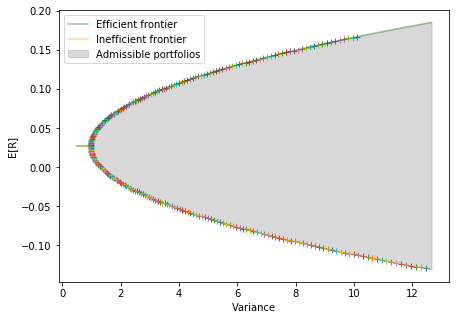

-----------    END Simulation      ---------- 
 
-----------    Simulation      ---------- 
 
Asset Covariance Matrix : 

          MSFT      AAPL
MSFT  1.174055  0.584937
AAPL  0.584937  1.642194 

pi :  [ 0.04833581 -0.0108826 ] 

max Green :  0.06965443501099726  max Cyan :  0.10755421561498077  max Blue :  0.1454539962189643  max Red :  0.16677262280870503


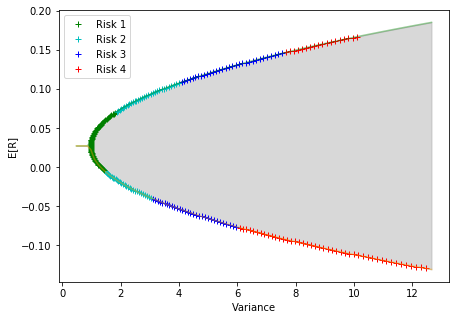

-----------    END Simulation      ---------- 
 


In [61]:
name = ["MSFT","AAPL"]
final_simulation(name,0.02,2)
final_simulation(name,0.02,2,True,0.1)

## 2) All possible portofolios with two assets choosen between Amazon, Walmart, Apple, Microsoft and Nasdaq :

          AAPL      MSFT
AAPL  1.642194  0.584937
MSFT  0.584937  1.174055
[-0.0108826   0.04833581]


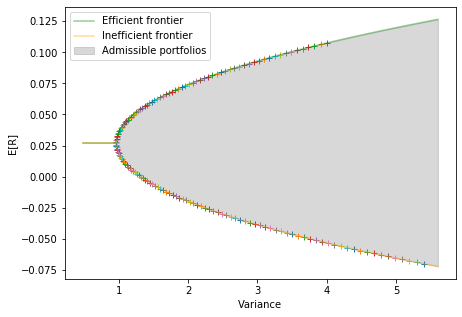

           WMT      MSFT
WMT   0.702007  0.258316
MSFT  0.258316  1.174055
[0.05272872 0.04833581]


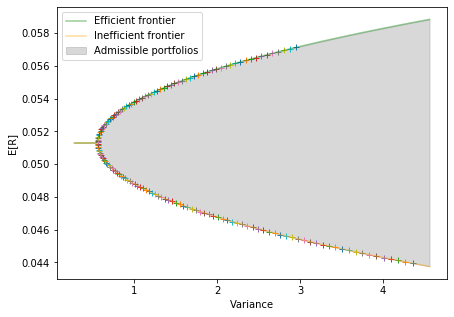

           WMT      AAPL
WMT   0.702007  0.238564
AAPL  0.238564  1.642194
[ 0.05272872 -0.0108826 ]


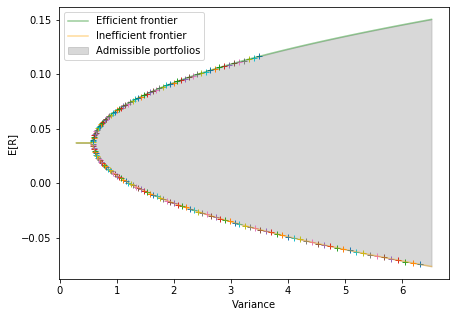

          AMZN      MSFT
AMZN  2.362448  0.670921
MSFT  0.670921  1.174055
[0.04417391 0.04833581]


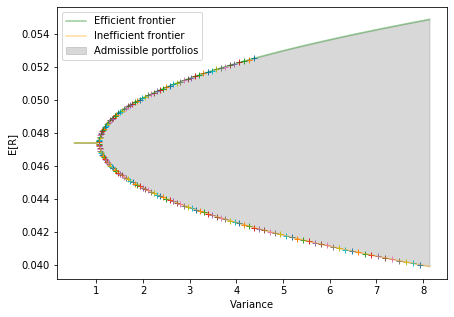

          AMZN      AAPL
AMZN  2.362448  0.784805
AAPL  0.784805  1.642194
[ 0.04417391 -0.0108826 ]


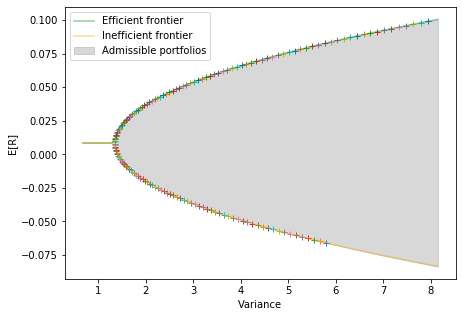

          AMZN       WMT
AMZN  2.362448  0.278771
WMT   0.278771  0.702007
[0.04417391 0.05272872]


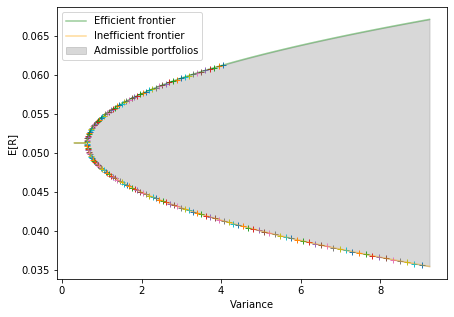

          NASD      MSFT
NASD  0.695257  0.595898
MSFT  0.595898  1.174055
[0.02865642 0.04833581]


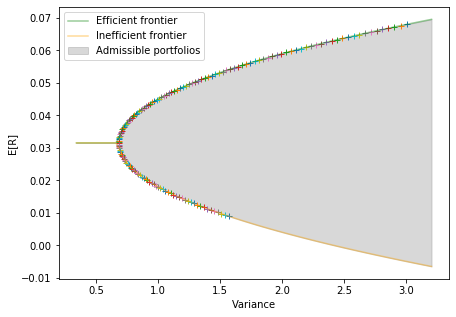

          NASD      AAPL
NASD  0.695257  0.708758
AAPL  0.708758  1.642194
[ 0.02865642 -0.0108826 ]


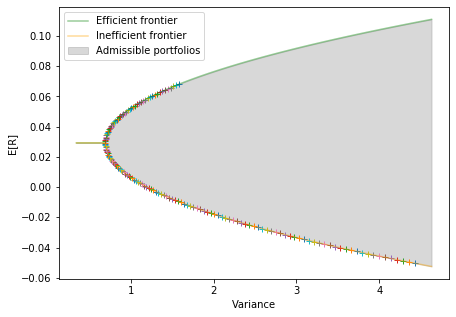

          NASD       WMT
NASD  0.695257  0.246610
WMT   0.246610  0.702007
[0.02865642 0.05272872]


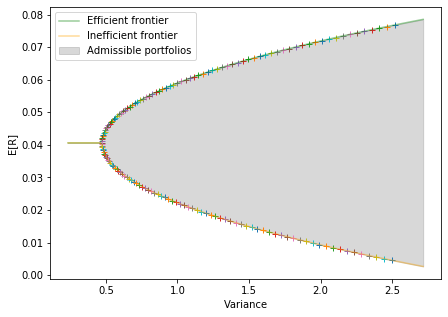

          NASD      AMZN
NASD  0.695257  0.823446
AMZN  0.823446  2.362448
[0.02865642 0.04417391]


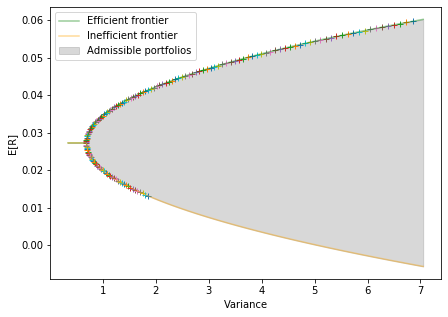

In [17]:
name = ["MSFT","AAPL","WMT","AMZN","NASD"]
for i in range(len(name)):
    for j in range(i):
        test = [name[i],name[j]]
        final_simulation(test,0.02,1)    

# II- Study of portfolios with 3 risky assets : 

## 1) Microsoft Apple and Amazon :

### With the short sale limit equal to 0 : 

          MSFT      AAPL      AMZN
MSFT  1.174055  0.584937  0.670921
AAPL  0.584937  1.642194  0.784805
AMZN  0.670921  0.784805  2.362448
[ 0.04833581 -0.0108826   0.04417391]


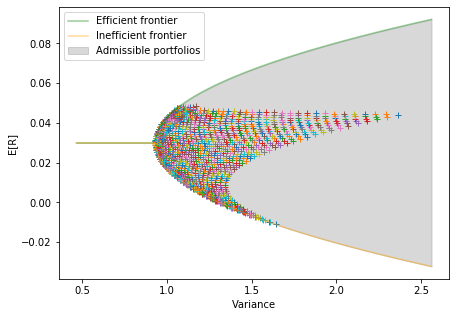

          MSFT      AAPL      AMZN
MSFT  1.174055  0.584937  0.670921
AAPL  0.584937  1.642194  0.784805
AMZN  0.670921  0.784805  2.362448
[ 0.04833581 -0.0108826   0.04417391]
max Green :  0.048335808421256524  max Cyan :  0.04692076321030935  max Blue :  0.04592190776728781  max Red :  0.04525600413860678


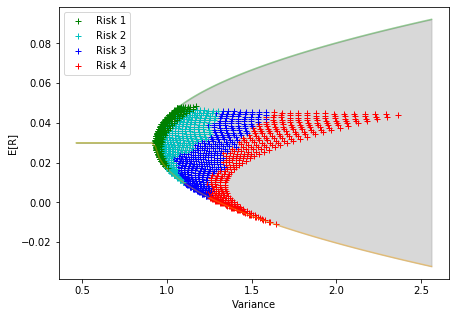

In [18]:
name = ["MSFT","AAPL","AMZN"]
final_simulation(name,0.02,0)
final_simulation(name,0.02,0,True,0.1)

### With the short sale limit equal to 1 : 

          MSFT      AAPL      AMZN
MSFT  1.174055  0.584937  0.670921
AAPL  0.584937  1.642194  0.784805
AMZN  0.670921  0.784805  2.362448
[ 0.04833581 -0.0108826   0.04417391]


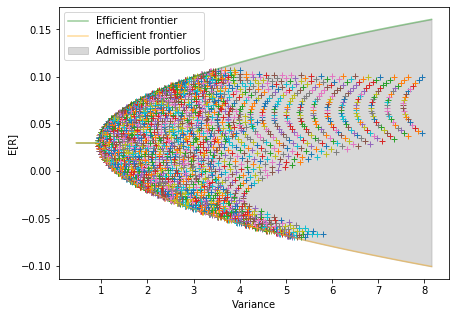

          MSFT      AAPL      AMZN
MSFT  1.174055  0.584937  0.670921
AAPL  0.584937  1.642194  0.784805
AMZN  0.670921  0.784805  2.362448
[ 0.04833581 -0.0108826   0.04417391]
max Green :  0.08199399878182569  max Cyan :  0.10079999535975707  max Blue :  0.10755421561498077  max Red :  0.10235184351591027


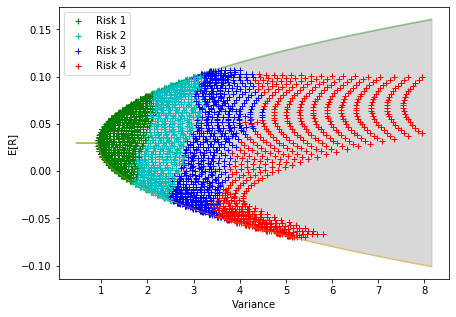

In [19]:
name = ["MSFT","AAPL","AMZN"]
final_simulation(name,0.05,1)
final_simulation(name,0.05,1,True,0.1)

## 2) All possible portfolios of 3 assets choosen between the five assets :

### We choose a short sale limit equal to 1

          MSFT      AAPL       WMT
MSFT  1.174055  0.584937  0.258316
AAPL  0.584937  1.642194  0.238564
WMT   0.258316  0.238564  0.702007
[ 0.04833581 -0.0108826   0.05272872]


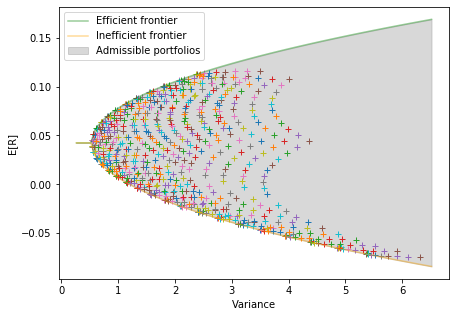

          MSFT      AAPL      AMZN
MSFT  1.174055  0.584937  0.670921
AAPL  0.584937  1.642194  0.784805
AMZN  0.670921  0.784805  2.362448
[ 0.04833581 -0.0108826   0.04417391]


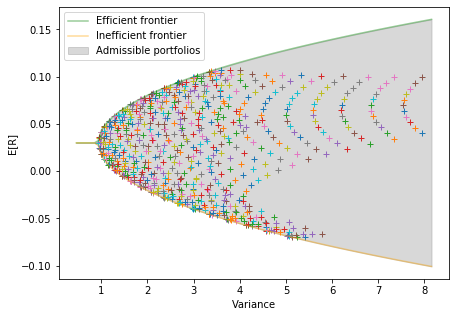

          MSFT      AAPL      NASD
MSFT  1.174055  0.584937  0.595898
AAPL  0.584937  1.642194  0.708758
NASD  0.595898  0.708758  0.695257
[ 0.04833581 -0.0108826   0.02865642]


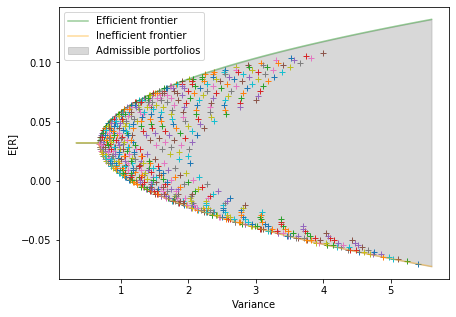

          MSFT       WMT      AMZN
MSFT  1.174055  0.258316  0.670921
WMT   0.258316  0.702007  0.278771
AMZN  0.670921  0.278771  2.362448
[0.04833581 0.05272872 0.04417391]


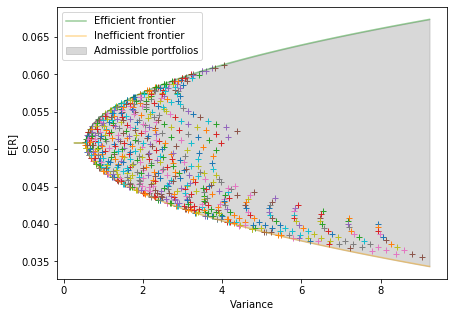

          MSFT       WMT      NASD
MSFT  1.174055  0.258316  0.595898
WMT   0.258316  0.702007  0.246610
NASD  0.595898  0.246610  0.695257
[0.04833581 0.05272872 0.02865642]


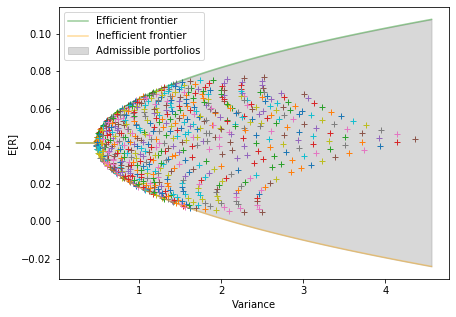

          MSFT      AMZN      NASD
MSFT  1.174055  0.670921  0.595898
AMZN  0.670921  2.362448  0.823446
NASD  0.595898  0.823446  0.695257
[0.04833581 0.04417391 0.02865642]


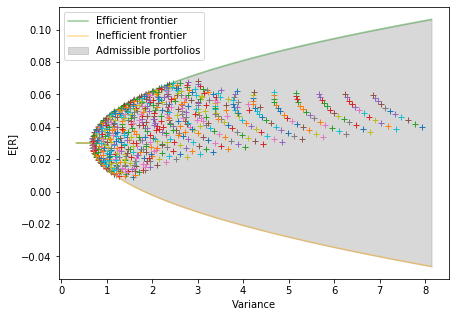

          AAPL       WMT      AMZN
AAPL  1.642194  0.238564  0.784805
WMT   0.238564  0.702007  0.278771
AMZN  0.784805  0.278771  2.362448
[-0.0108826   0.05272872  0.04417391]


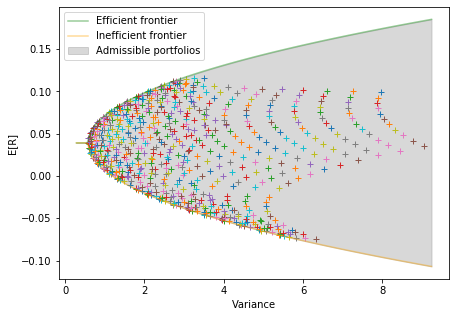

          AAPL       WMT      NASD
AAPL  1.642194  0.238564  0.708758
WMT   0.238564  0.702007  0.246610
NASD  0.708758  0.246610  0.695257
[-0.0108826   0.05272872  0.02865642]


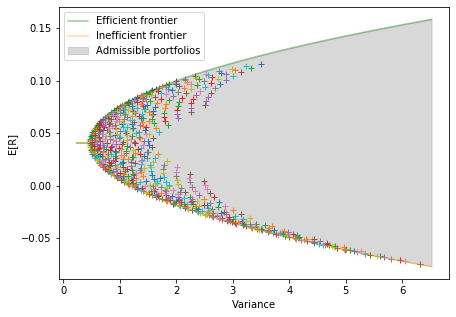

          AAPL      AMZN      NASD
AAPL  1.642194  0.784805  0.708758
AMZN  0.784805  2.362448  0.823446
NASD  0.708758  0.823446  0.695257
[-0.0108826   0.04417391  0.02865642]


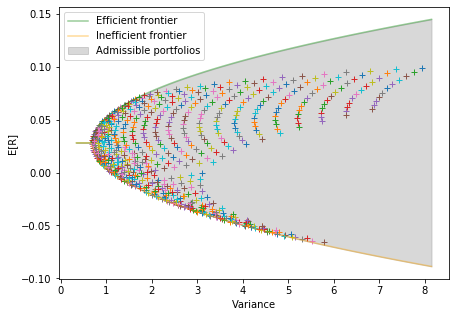

           WMT      AMZN      NASD
WMT   0.702007  0.278771  0.246610
AMZN  0.278771  2.362448  0.823446
NASD  0.246610  0.823446  0.695257
[0.05272872 0.04417391 0.02865642]


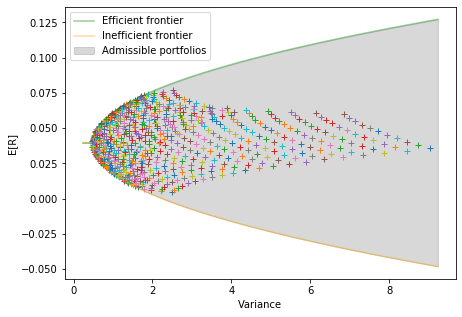

In [20]:
name = ["MSFT","AAPL","WMT","AMZN","NASD"]
for i in range(len(name)-2):
    for j in range(i+1,len(name)-1):
        for k in range(j+1,len(name)):
                test = [name[i],name[j],name[k]]
                final_simulation(test,0.1,1)

# III- Study of a portfolio with 5 assets  : 

##  Microsoft, Apple, Amazon, WMT, Nasdaq :

          MSFT      AAPL       WMT      AMZN      NASD
MSFT  1.174055  0.584937  0.258316  0.670921  0.595898
AAPL  0.584937  1.642194  0.238564  0.784805  0.708758
WMT   0.258316  0.238564  0.702007  0.278771  0.246610
AMZN  0.670921  0.784805  0.278771  2.362448  0.823446
NASD  0.595898  0.708758  0.246610  0.823446  0.695257
[ 0.04833581 -0.0108826   0.05272872  0.04417391  0.02865642]


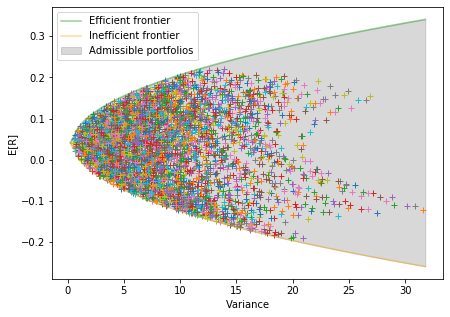

          MSFT      AAPL       WMT      AMZN      NASD
MSFT  1.174055  0.584937  0.258316  0.670921  0.595898
AAPL  0.584937  1.642194  0.238564  0.784805  0.708758
WMT   0.258316  0.238564  0.702007  0.278771  0.246610
AMZN  0.670921  0.784805  0.278771  2.362448  0.823446
NASD  0.595898  0.708758  0.246610  0.823446  0.695257
[ 0.04833581 -0.0108826   0.05272872  0.04417391  0.02865642]
max Green :  0.15368260099594366  max Cyan :  0.1812362337935852  max Blue :  0.21503271311011132  max Red :  0.21931011608751333


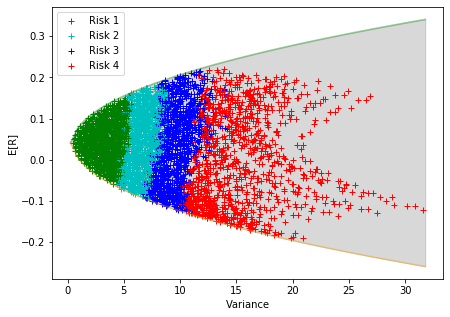

In [21]:
name = ["MSFT","AAPL","WMT","AMZN","NASD"]
final_simulation(name,0.5,2)
final_simulation(name,0.5,2,True,0.1)

# IV Optimised solution for a given Variance :

In [22]:
def Opt_pi (name,var):
    R,M = generate_R_M(name)
    S = R.cov()
    S_inv = npl.inv(S)
    
    un = np.zeros(len(name))+1
    a = (un.T).dot(np.dot(S_inv,un))
    b = (un.T).dot(np.dot(S_inv,M))
    
    term1 = (1/a)*np.dot(S_inv,un)
    A = M - (b/a)*un
    NA = np.sqrt(np.dot(A,np.dot(S_inv,A)))
    
    return term1 + (np.sqrt(var -1/a)/NA) * np.dot(S_inv,A)

          MSFT      AAPL      AMZN
MSFT  1.174055  0.584937  0.670921
AAPL  0.584937  1.642194  0.784805
AMZN  0.670921  0.784805  2.362448
[ 0.04833581 -0.0108826   0.04417391]
pi optimal :  [ 1.19522364 -0.56518481  0.36996116]


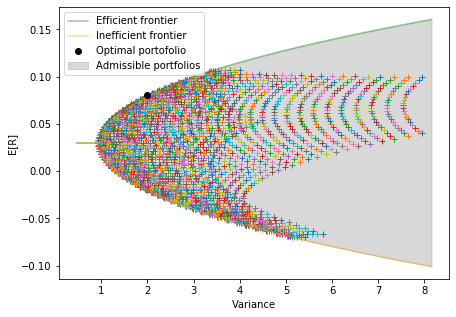

In [23]:
name = ["MSFT","AAPL","AMZN"]
pi_o = Opt_pi(name,2)
final_simulation(name,0.05,1,False,0,False,pi_o)
print("pi optimal : ",pi_o)

# V- Numerical computation of the Value at risk for real datas:

## Value at Risk Evolution for a given $\pi$ : 

-0.999550362656608

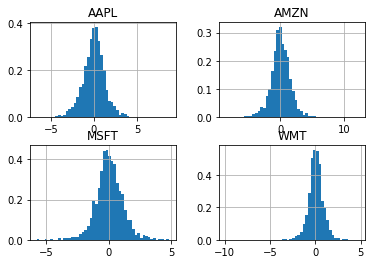

In [24]:
name = ["AMZN","AAPL","MSFT","WMT"]
#Step 1 : création de R 
R,M = generate_R_M(name)

#Show the distribution of the profitabilities
R.hist(bins=50,density=True)
PI= [0.1, 0.2, 0.5, 0.2]   

Calcul_VAR_PI(R.T, PI,0.9)

#Calcul_VAR_PI2(R,PI,0.9)


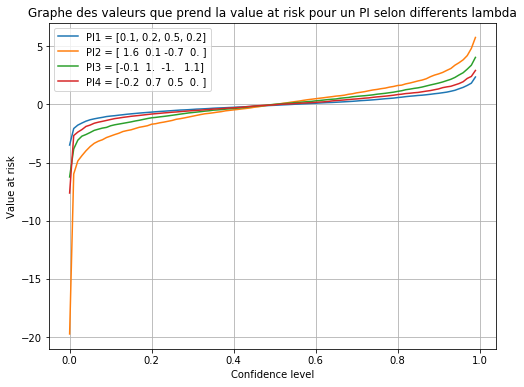

In [25]:
PI2 = generate_PI (4,1,0.1)
PI3 = generate_PI (4,1,0.1)
PI4 = generate_PI (4,1,0.1)

#Step 2 : 
lbda_test=np.arange(0,1,0.01)

t1=np.zeros(len(lbda_test))
t2=np.zeros(len(lbda_test))
t3=np.zeros(len(lbda_test))
t4=np.zeros(len(lbda_test))
for i in range(len(lbda_test)):
    
    t1[i]=(Calcul_VAR_PI(R.T,PI, 1-lbda_test[i]))
    t2[i]=(Calcul_VAR_PI(R.T,PI2, 1-lbda_test[i]))
    t3[i]=(Calcul_VAR_PI(R.T,PI3, 1-lbda_test[i]))
    t4[i]=(Calcul_VAR_PI(R.T,PI4, 1-lbda_test[i]))
plt.figure(1, figsize=(8, 6))
plt.title("Graphe des valeurs que prend la value at risk pour un PI selon differents lambda")
plt.plot(lbda_test,t1,label = "PI1 = "+str(PI))
plt.plot(lbda_test,t2,label = "PI2 = "+str(PI2))
plt.plot(lbda_test,t3,label = "PI3 = "+str(PI3))
plt.plot(lbda_test,t4,label = "PI4 = "+str(PI4))
plt.xlabel("Confidence level")
plt.ylabel("Value at risk")
plt.legend()
plt.grid()
plt.show()

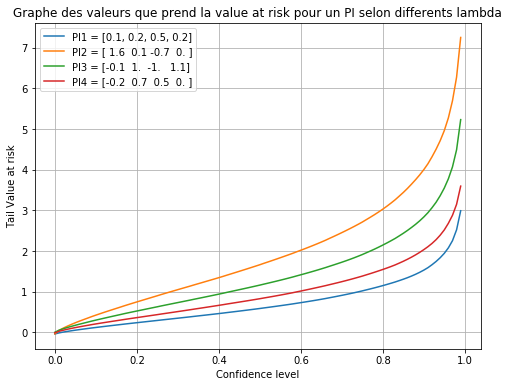

In [26]:
lbda_test=np.arange(0,1,0.01)

t1=np.zeros(len(lbda_test))
t2=np.zeros(len(lbda_test))
t3=np.zeros(len(lbda_test))
t4=np.zeros(len(lbda_test))
for i in range(len(lbda_test)):
    
    t1[i]=(Calcul_TAIL_VAR_PI(R.T,PI, 1-lbda_test[i]))
    t2[i]=(Calcul_TAIL_VAR_PI(R.T,PI2, 1-lbda_test[i]))
    t3[i]=(Calcul_TAIL_VAR_PI(R.T,PI3, 1-lbda_test[i]))
    t4[i]=(Calcul_TAIL_VAR_PI(R.T,PI4, 1-lbda_test[i]))
plt.figure(1, figsize=(8, 6))
plt.title("Graphe des valeurs que prend la value at risk pour un PI selon differents lambda")
plt.plot(lbda_test,t1,label = "PI1 = "+str(PI))
plt.plot(lbda_test,t2,label = "PI2 = "+str(PI2))
plt.plot(lbda_test,t3,label = "PI3 = "+str(PI3))
plt.plot(lbda_test,t4,label = "PI4 = "+str(PI4))
plt.xlabel("Confidence level")
plt.ylabel("Tail Value at risk")
plt.grid()
plt.legend()
plt.show()

## Graphic representation of the V@R : 

In [27]:
## This function compute the optimum pi for a given level of risk
#without applying any optimisation problem
def max_PI (name,risk,step,ss_limit,lbda):
    n = len(name)
    
    df_ret,M = generate_R_M(name)
        
    simu_pi = import_pi(n,step,0,ss_limit)
    #simulation_ss(n, step,0,ss_limit)
    
    
    VAR =[]
    for j in range(simu_pi.shape[0]): 
        PI0 = simu_pi[j,:]
        VAR.append(Calcul_VAR_PI(df_ret.T,PI0,lbda))
    C1 = np.quantile(VAR, .25)
    C2 = np.quantile(VAR, .50)
    C3 = np.quantile(VAR, .75)
    maxi = 0

    for i in simu_pi:
        if risk_condition(df_ret.T,i,lbda,risk,C1,C2,C3):
            
            cout = i.dot(M)
            if cout>maxi:
                pi_opti = i
                maxi = cout
    
    return pi_opti


[ 1.7 -0.9  0.2]
          MSFT      AAPL      AMZN
MSFT  1.174055  0.584937  0.670921
AAPL  0.584937  1.642194  0.784805
AMZN  0.670921  0.784805  2.362448
[ 0.04833581 -0.0108826   0.04417391]
max Green :  0.08199399878182569  max Cyan :  0.10079999535975707  max Blue :  0.10755421561498077  max Red :  0.10235184351591027


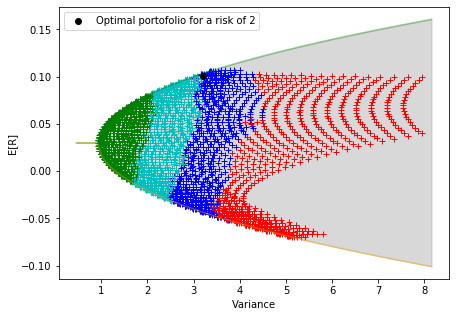

In [28]:
#name = ["AMZN","AAPL","MSFT"]
name = ["MSFT","AAPL","AMZN"]
ss_limit = 1
step = 0.05
lbda = 0.1
risk = 2


pi_opti = max_PI(name,risk,step,ss_limit,lbda)
print(pi_opti)
#Recall arguments of final_simulation
#final_simulation (name,step,ss_limit,disp_VAR = False,lbda=0,show =True,pi_opti=[], risk=0)
final_simulation(name,step,ss_limit,True,lbda,True,pi_opti,risk)

# VI- Stochastic Optimisation Problem :

## Part A : with the V@R in the cost function

In [29]:
# --------Cost function to minimize-----------
def cost_function (R,PI,M,lbda):
    return -PI.dot(M) + Calcul_VAR_PI(R,PI,lbda)

In [30]:
#-------Return a neighbour of pi (2 coefficients change of the value of the discretization step)-----------

def swap(pi,ss_limit,step):
    result = np.copy(pi)
    vec = np.arange(0,len(pi))
    index = np.random.choice(len(pi), 2,replace =False)
    
    #Cas où on tombe sur 2 valeurs identiques "sur les bords"
    #------
    cond = (pi[index[0]]==pi[index[1]]) and ((pi[index[0]]==-ss_limit) or (pi[index[0]]==ss_limit +1))
    while cond : 
        index = np.random.choice(len(pi), 2,replace =False)
        cond = (pi[index[0]]==pi[index[1]]) and ((pi[index[0]]==-ss_limit) or (pi[index[0]]==ss_limit +1))
    #-----
    
    # Conditions necessaires pour ne pas dépasser le "ss_limit" :
    if (pi[index[0]] == -ss_limit):
        result[index[0]] += step
        result[index[1]] -= step
    elif (pi[index[0]] == ss_limit+1):
        result[index[0]] -= step
        result[index[1]] += step
    elif (pi[index[1]] == -ss_limit):
        result[index[0]] -= step
        result[index[1]] += step
    elif (pi[index[1]] == ss_limit+1):
        result[index[0]] += step
        result[index[1]] -= step
    else:
        result[index[0]] += step
        result[index[1]] -= step
    
    return np.around(result, decimals=4)
       
    

#----------ALGORITHME DE METROPOLIS CLASSIQUE------------
def recuit (nit,ss_limit,step,h,M,lbda,R,dim):
    #Initialisation
 
    pi = generate_PI(dim,ss_limit,step)
    f1 = cost_function(R,pi,M,lbda)
    n=2
    H=[]
    while n<nit :
        pi2 = swap(pi,ss_limit,step)
        f2 = cost_function(R,pi2,M,lbda)
        H.append(np.abs(f1-f2))
        if random() < np.min((1,np.exp((f1-f2)/(h/np.log(n))))):
            pi = pi2
            f1 = f2
        n += 1
    return pi,np.max(H)

In [31]:
#---------RECHERCHE DU PI OPTIMAL EN UTILISANT RECUITé----------

def PI_opti_recuit (name,ss_limit,step,lbda,h,nit):
    # !!!!!!!!! Paramètre à adapter au problème :  !!!!!!!!!!!!
    
    #h = 0.1
    #print(1)
    #---- Extraction des données-----SURTOUT REMPLISSAGE DE R !
    dim = len(name)
    
    R,M=generate_R_M(name)
    R = R.T
    #----------------------------------
    #R= pd.DataFrame(R.T,columns=noms)
    
    return recuit(nit,ss_limit,step,h,M,lbda,R,dim)

## Empirical solution in a small dimension case :

Computing the empirical solution in a small dimension case allow us to see if our optimisation algorithm works.

In [32]:
name = ["MSFT","AAPL","AMZN"]
lbda = 0.1
#risk = 2
#Step 1 : création de R 
dim = len(name)

R,M=generate_R_M(name)
R = R.T
simul = import_pi(dim,0.05,0,1)
#simulation_ss(dim,0.05,0,1)
mini = 1000
print(simul.shape)
p = []
for i in range(simul.shape[0]):
    #print(i)
    a = cost_function(R,simul[i,:],M,lbda)
    p.append(a)
    if a <= mini:
        mini = a
        pi_max = simul[i,:]
print("Empirical Solution" + str(pi_max))

(2651, 3)
Empirical Solution[0.7  0.25 0.05]


#### Evolution of the Cost Function when seeking the empirical solution: 

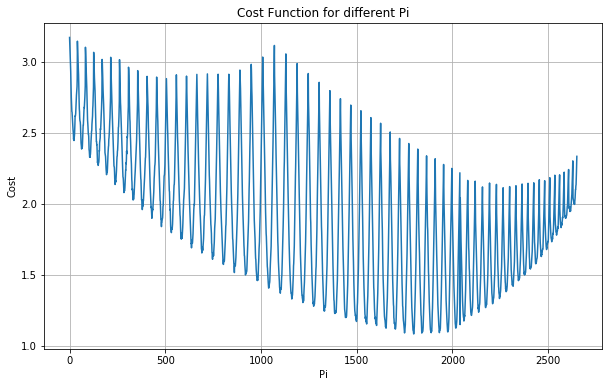

In [33]:
plt.figure(figsize=(10,6))
plt.grid()
plt.ylabel("Cost")
plt.xlabel("Pi")
plt.title("Cost Function for different Pi")
plt.plot(p)
plt.show()

## Test of the optimisation Algorithm : 

In [34]:
name = ["MSFT","AAPL","AMZN"]
h= 0.03
nit = 10000
ss_limit0=1
step =0.05
lbda0=0.1
pi_opti_recuit,H= PI_opti_recuit(name,ss_limit0,step,lbda0,h,nit)

In [35]:
print("Empirical Solution : "+ str(pi_max))
print("Algorithm solution : "+ str(pi_opti_recuit))
print("Maximum jump encoutered during the Algorithm : "+ str(H))

Empirical Solution : [0.7  0.25 0.05]
Algorithm solution : [0.7 0.2 0.1]
Maximum jump encoutered during the Algorithm : 0.06852632078456433


### Comparison on the graph :

          MSFT      AAPL      AMZN
MSFT  1.174055  0.584937  0.670921
AAPL  0.584937  1.642194  0.784805
AMZN  0.670921  0.784805  2.362448
[ 0.04833581 -0.0108826   0.04417391]
max Green :  0.08199399878182569  max Cyan :  0.10079999535975707  max Blue :  0.10755421561498077  max Red :  0.10235184351591027


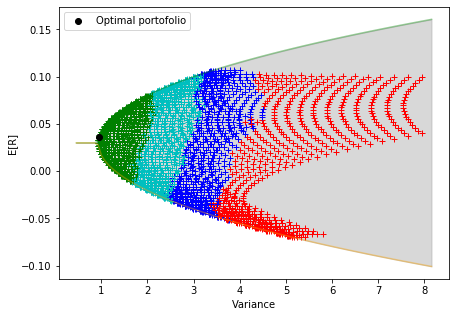

In [36]:
name = ["MSFT","AAPL","AMZN"]
ss_limit0=1
step =0.05
lbda0=0.1

#final_simulation (name,step,ss_limit,disp_VAR = False,lbda=0,show =True,pi_opti=[], risk=0)

#empirical solution
#final_simulation(name,step,1,True,lbda0,True,pi_max)

#recuit solution
final_simulation(name,step,1,True,lbda0,True,pi_opti_recuit)

## Part B : without the value at risk as a constraint (and not in the cost function)

In [37]:
#-------Cost function2-----------------------
def cost_function2 (PI,M):
    return -PI.dot(M)

In [38]:
#--------------------SWAP WITH VAR --------------------------------------
def swap2(pi,ss_limit,step,v0,R,lbda):
    #result = np.copy(pi)
    vec = np.arange(0,len(pi))
    cond_var = False
    
    while not cond_var:
        #Cas où on tombe sur 2 valeurs identiques "sur les bords"
        #------
        result=np.copy(pi)
        index = np.random.choice(len(pi), 2,replace =False)
        cond = (result[index[0]]==result[index[1]]) and ((result[index[0]]==-ss_limit) or (result[index[0]]==ss_limit +1))
        while cond : 
            index = np.random.choice(len(pi), 2,replace =False)
            cond = (result[index[0]]==result[index[1]]) and ((result[index[0]]==-ss_limit) or (result[index[0]]==ss_limit +1))
        #-----

        # Conditions necessaires pour ne pas dépasser le "ss_limit" :
        if (result[index[0]] == -ss_limit):
            result[index[0]] += step
            result[index[1]] -= step
        elif (result[index[0]] == ss_limit+1):
            result[index[0]] -= step
            result[index[1]] += step
        elif (result[index[1]] == -ss_limit):
            result[index[0]] -= step
            result[index[1]] += step
        elif (result[index[1]] == ss_limit+1):
            result[index[0]] += step
            result[index[1]] -= step
        else:
            result[index[0]] += step
            result[index[1]] -= step

        result = np.around(result, decimals=4)

        if Calcul_VAR_PI(R,result,lbda) <= v0:
            cond_var= True
            pi_neighbour = result
          
    return pi_neighbour

###---------- Recuit VAR-------+
def recuit2 (nit,ss_limit,step,h,M,lbda,R,dim,v0):
    #Initialisation
    VAR=[]
    tab_cost=[]
    pi = generate_PI(dim,ss_limit,step)
    while not Calcul_VAR_PI(R,pi, lbda) <= v0:
        pi = generate_PI(dim,ss_limit,step)
    VAR.append(Calcul_VAR_PI(R,pi,lbda))    
    f1 = cost_function2(pi,M)
    n=2
    H=[]
    tab_cost.append(f1)
    while n<nit :
        pi2 = swap2(pi,ss_limit,step,v0,R,lbda)
        f2 = cost_function2(pi2,M)
        H.append(np.abs(f1-f2))
        if random() < np.min((1,np.exp((f1-f2)/(h/np.log(n))))):
            pi = pi2
            f1 = f2
            tab_cost.append(f1)
            VAR.append(Calcul_VAR_PI(R,pi,lbda))    

        n += 1
    return pi,np.max(H),VAR, tab_cost

In [39]:
#--- with VAR ----

def PI_opti_recuit2 (name,ss_limit,step,lbda,h,nit,v0):
    # !!!!!!!!! Paramètre à adapter au problème :  !!!!!!!!!!!!
    
    #h = 0.1
    #print(1)
    #---- Extraction des données-----SURTOUT REMPLISSAGE DE R !
    dim = len(name)
    
    R,M=generate_R_M(name)
    R = R.T
    #----------------------------------
    #R= pd.DataFrame(R.T,columns=noms)
    
    return recuit2(nit,ss_limit,step,h,M,lbda,R,dim,v0)

### Test of the optimisation algorithm :

In [40]:
#Real empiric research :
#name = ["AMZN","AAPL","MSFT","WMT"]
name = ["MSFT","AAPL","AMZN"]
lbda = 0.1
#risk = 2
#Step 1 : création de R 
dim = len(name)
v0=2
R,M=generate_R_M(name)
R = R.T
simul = import_pi(dim,0.05,0,1)
#simulation_ss(dim,0.05,0,1)
mini = 1000
p = []
for i in range(simul.shape[0]):
        if Calcul_VAR_PI(R,simul[i,:],lbda) <= v0:
            a = cost_function2(simul[i,:],M)
            p.append(a)
            if a <= mini:
                mini = a
                pi_max2 = simul[i,:]
print("Empirical Solution" + str(pi_max2))
print("Value at risk of this portfolio",Calcul_VAR_PI(R,pi_max2,lbda))

Empirical Solution[ 1.8  -0.95  0.15]
Value at risk of this portfolio 1.9969657475890614


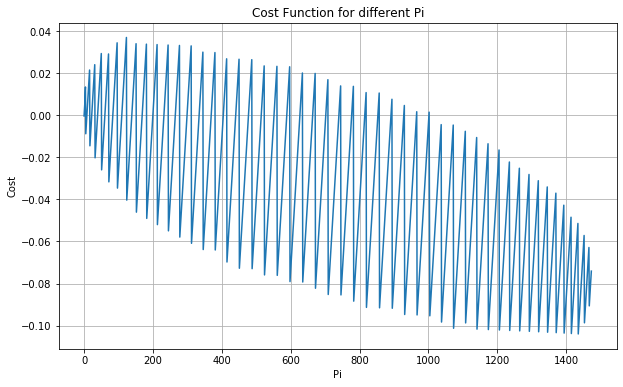

In [41]:
plt.figure(figsize=(10,6))
plt.grid()
plt.ylabel("Cost")
plt.xlabel("Pi")
plt.title("Cost Function for different Pi")
plt.plot(p)
plt.show()

In [42]:
#name = ["AMZN","AAPL","MSFT","WMT"]
name = ["MSFT","AAPL","AMZN"]

h= 0.005
nit = 5000
ss_limit0=1
step =0.05
lbda0=0.1
pi_opti_recuit2,H,tab_VAR,tab_cost= PI_opti_recuit2(name,ss_limit0,step,lbda0,h,nit,2)
print("Empirical Solution : "+ str(pi_max2))
print("Algorithm solution : "+ str(pi_opti_recuit2))
print("Maximum jump encoutered during the Algorithm : "+ str(H))

Empirical Solution : [ 1.8  -0.95  0.15]
Algorithm solution : [ 1.5  -0.95  0.45]
Maximum jump encoutered during the Algorithm : 0.002960920359686231


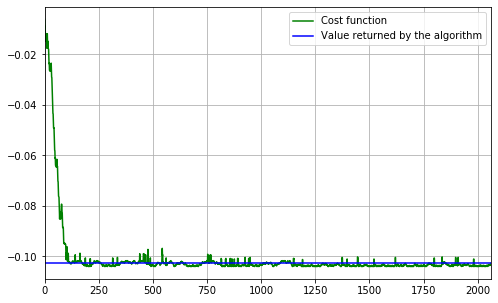

-0.10272044129962919
-0.1039690106034061


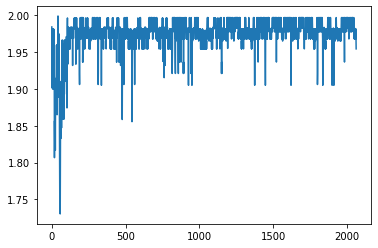

In [43]:
plt.figure(figsize=(8,5))
plt.grid()
plt.plot(tab_cost,'g', label ="Cost function" )
x=np.arange(0,len(tab_cost))
plt.plot([0,len(x)],[tab_cost[-1],tab_cost[-1]],'b', label = "Value returned by the algorithm")
plt.xlim(0,len(x))
plt.legend()
plt.show()
print(tab_cost[-1])
print(np.min(tab_cost))
mini = np.min(tab_cost)
a=tab_cost<=mini
plt.plot(tab_VAR)

          MSFT      AAPL      AMZN
MSFT  1.174055  0.584937  0.670921
AAPL  0.584937  1.642194  0.784805
AMZN  0.670921  0.784805  2.362448
[ 0.04833581 -0.0108826   0.04417391]
max Green :  0.08199399878182569  max Cyan :  0.10079999535975707  max Blue :  0.10755421561498077  max Red :  0.10235184351591027


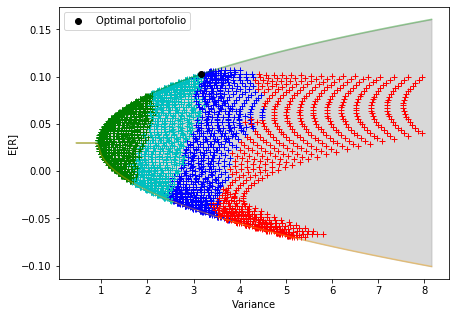

In [44]:
name = ["MSFT","AAPL","AMZN"]
ss_limit0=1
step =0.05
lbda0=0.1

#final_simulation (name,step,ss_limit,disp_VAR = False,lbda=0,show =True,pi_opti=[], risk=0)

#empirical solution
#final_simulation(name,step,1,True,lbda0,True,pi_max2)

#recuit solution
final_simulation(name,step,1,True,lbda0,True,pi_opti_recuit2)

# Test avec l'autre problème d'optimisation

## Cas 2 actifs

In [45]:
#définition des variables pour ce problème :
# on les a déja défini plus haut par a1,b1,...

In [46]:
#fonction qui pour un m donné nous renvoie le sigma minimal

def var_m(un,a,b,M,S_inv,m):
    Norm_M = np.dot( M , np.dot(S_inv,M) ) #norme de M au carré
    K= 1 - (a*Norm_M)/b**2
    #lambda :
    l = (-2/b + 2*a*m/b**2)/K
    #mu : 
    mu= (-l*Norm_M -2*m)/b
    #lambda * M
    lM = np.dot(l,M)
    #mu * un
    mu1= np.dot(mu,un)
    
    #portefeuille optimal
    pi_star = 1/2 * np.dot(S_inv,-lM -mu1)
    
    #variance pour ce portefeuille :
    
    var = np.dot( (pi_star) , np.dot(npl.inv(S_inv),pi_star) )
    return var

def m_sigma(un,a,b,M,S_inv,sigma2):
    if sigma2 < 1/a :
        return b/a
    K = M - (b/a)*un
    NK = np.sqrt(K.dot(np.dot(S_inv,K)))
    A = np.sqrt(sigma2 -1/a)
    m = np.zeros(2)
    #print(m)
    m[0] = b/a + A*NK
    m[1] = b/a - A*NK
    #print(m)
    return m

In [74]:
#nous renvoie le plus grand m pour un sigma fixé)
#Var_R1 est une des variances pour un portefeuille composé de 2 actifs testé précedemment
#Idem pour E_R1 qui est associé au même portefeuille
n = len(name)
pi= import_pi(n,0.1,0,0)[2,:]
un = np.zeros(len(name))+1
df_ret,M = generate_R_M(name)
mat_cov = df_ret.cov()
un = np.ones(n)
mat_cov_inv= npl.inv(mat_cov)
a = (un.T).dot(np.dot(mat_cov_inv,un))
b = (un.T).dot(np.dot(mat_cov_inv,M))
E_R = np.dot(pi,M)
Var_R = np.dot(pi, np.dot(mat_cov,pi))
test0=m_sigma(un,a,b,M,npl.inv(mat_cov),Var_R)
print("Variance fixée à : " + str(Var_R) )
print("Meilleure espérance de rentabilité possible " + str(test0[0]) )

Variance fixée à : 1.2851463725131569
Meilleure espérance de rentabilité possible 0.05333059237575997


In [75]:
#nous renvoie le plus petit sigma pour un m fixé
test1 = var_m(un,a,b,M,npl.inv(mat_cov),E_R)
print("Espérance fixée à : " + str(E_R) )
print("Plus petite variance possible : " + str(test1))

Espérance fixée à : 0.000961082666277124
Plus petite variance possible : 1.2851463725131578


Les 2 problèmes sont effectivement équivalents : test1 = Var_R1

# Best portfolio with a given value at risk

In [76]:
from sklearn.linear_model import LogisticRegression
from scipy.optimize import fsolve
from scipy import stats


In [77]:
def disp_portfolio2(R,M,mat_cov,step,ss_limit,given_VAR,lbda,epsilon):
    n = np.shape(M)[0]
    pi = simulation_ss(n,step,0,ss_limit)
    maxi = 0
    mini = np.inf
    plt.figure(1,figsize=(7, 5))
    
    VAR =[]
    for j in range(pi.shape[0]): 
        PI0 = pi[j,:]
        VAR.append(Calcul_VAR_PI(R,PI0,lbda))
    VAR = np.array(VAR)
    
    V = []
    Er = []
    Y = []
    for i in range(pi.shape[0]):
        
        PI = pi[i,:]
        E_R = np.dot(PI,M)
        Var_R = np.dot(PI, np.dot(mat_cov,PI))
        
        
        cond = VAR[i] <= (given_VAR + epsilon) and VAR[i] >= (given_VAR-epsilon)
        if cond:
            if VAR[i] <= (given_VAR):
                plt.plot(Var_R,E_R,'r+')
                Y.append(0)
                
            else:
                plt.plot(Var_R,E_R,'b+')
                Y.append(1)
                
            V.append(Var_R)
            Er.append(E_R)
        
            if Var_R < mini:
                mini = Var_R

            if Var_R > maxi:
                maxi = Var_R
            
    return mini,maxi,np.array(V),np.array(Er),np.array(Y)

In [78]:
def final_simulation2 (name,step,ss_limit,given_VAR,lbda,epsilon,show =True):
    n = len(name)
    
    df_ret,M = generate_R_M(name)
    
    mat_cov = df_ret.cov()
    un = np.ones(n)
    mat_cov_inv= npl.inv(mat_cov)
    a = (un.T).dot(np.dot(mat_cov_inv,un))
    b = (un.T).dot(np.dot(mat_cov_inv,M))
    print(mat_cov)
    print(M)
    S_min,S_Max,V,Er,Y = disp_portfolio2(df_ret.T,M,mat_cov,step,ss_limit,given_VAR,lbda,epsilon)
    
    Sigma = np.linspace(S_min*0.1,S_Max+0.2,100)
    
    E = graph(un,a,b,M,mat_cov_inv,Sigma)
    
    
    #----------------------- Linear regression -----------------------
    
    X = pd.DataFrame(V, columns =['Variance'])
    #X['Var_carr'] = pd.DataFrame(V**2)
    X['Return'] = pd.DataFrame(Er)
    Y = pd.DataFrame(Y, columns =['Col'])
    logreg = LogisticRegression(C=1e5,solver = 'newton-cg')
    logreg.fit(X, Y)
    
    #slope = logreg.coef_[0][0]/(-logreg.coef_[0][2])
    #slope2 = logreg.coef_[0][1]/(-logreg.coef_[0][2])
    #intercept = logreg.intercept_[0]/(-logreg.coef_[0][2])
    slope = logreg.coef_[0][0]/(-logreg.coef_[0][1])
    intercept = logreg.intercept_[0]/(-logreg.coef_[0][1])
    
    #-----------------------Intersection point -----------------------
    
    func = lambda s : slope * s +  intercept - m_sigma(un,a,b,M,mat_cov_inv,s)[0] # + slope2*s**2
    s0 = S_Max
    sol_s = fsolve(func, s0)[0]
    print(sol_s)
    t = np.linspace(S_min,sol_s*1.02,100)
    y = slope *t + intercept #+ slope2*t**2
    plt.plot(t,y)
    
    #----------------------- Pi_opti -----------------------
    
    term1 = (1/a)*np.dot(mat_cov_inv,un)
    A = M - (b/a)*un
    NA = np.sqrt(np.dot(A,np.dot(mat_cov_inv,A)))
    
    pi_opti = term1 + (np.sqrt(sol_s -1/a)/NA) * np.dot(mat_cov_inv,A)
    
    
    #-----------------------plot PI_opti -----------------------
    
    E_opti= np.dot(pi_opti,M)
    plt.plot(sol_s,E_opti,'ko',label = "Optimal portofolio with a VAR of "+str(given_VAR))
    plt.legend()
    
    
    #----------------------- Verification -----------------------
    
    print("pi_opti = ",pi_opti)
    print("VAR = ", Calcul_VAR_PI(df_ret.T,pi_opti,lbda))
    
    
    if show:
        plt.show()
    #return V,Er,Y

          MSFT      AAPL      AMZN
MSFT  1.174055  0.584937  0.670921
AAPL  0.584937  1.642194  0.784805
AMZN  0.670921  0.784805  2.362448
[ 0.04833581 -0.0108826   0.04417391]
3.358827547292774
pi_opti =  [ 1.51392755 -1.0040286   0.49010105]
VAR =  2.037069795955938


C:\Users\maxdo\anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


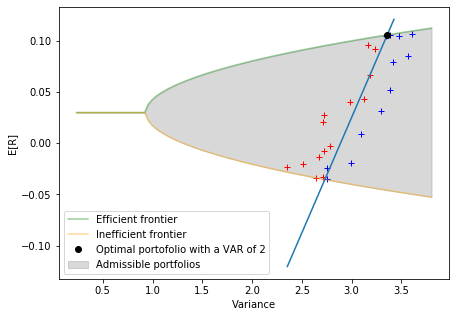

In [79]:
name = ["MSFT","AAPL","AMZN"]
ss_limit=5
step =0.2
lbda=0.1
epsilon = 0.1
given_VAR = 2

#V,Er,Y = final_simulation2(name,step,ss_limit,given_VAR,lbda)
final_simulation2(name,step,ss_limit,given_VAR,lbda,epsilon)